# Imports

In [1]:
# standard library imports
import os

# third-party imports
import boto3
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from botocore import UNSIGNED
from botocore.config import Config
from sklearn.model_selection import train_test_split

# Load data

In [2]:
# initialise the S3 client
s3 = boto3.client('s3', config=Config(signature_version=UNSIGNED))

# local folder to save the data
dataset_folder = '/Users/renatoboemer/code/developer/aot-object-tracking-aws/raw_data/airborne_data'

# list the bucket contents
bucket_name = 'airborne-obj-detection-challenge-training'
prefix = 'part1/'
result = s3.list_objects_v2(Bucket=bucket_name)

# initialise helper functions
def download_annotations(bucket, key, local_path):
    s3.download_file(bucket, key, local_path)

## Annotations: Groundtruth file

In [8]:
download_annotations(bucket_name, prefix + 'ImageSets/groundtruth.csv', os.path.join(dataset_folder, 'groundtruth.csv'))

In [3]:
gt_data = pd.read_csv(os.path.join(dataset_folder, 'groundtruth.csv'), index_col=0)
gt_data.head(2)

,time,flight_id,img_name,frame,id,range_distance_m,is_above_horizon,size_width,size_height,gt_left,gt_top,gt_right,gt_bottom
0,1566556045879430639,673f29c3e4b4428fa26bc55d812d45d9,1566556045879430639673f29c3e4b4428fa26bc55d812...,3,NaN,NaN,NaN,2448,2048,NaN,NaN,NaN,NaN
1,1566556046008821070,673f29c3e4b4428fa26bc55d812d45d9,1566556046008821070673f29c3e4b4428fa26bc55d812...,4,NaN,NaN,NaN,2448,2048,NaN,NaN,NaN,NaN


In [4]:
gt_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1808316 entries, 0 to 1808315
Data columns (total 13 columns):
 #   Column            Dtype  
---  ------            -----  
 0   time              int64  
 1   flight_id         object 
 2   img_name          object 
 3   frame             int64  
 4   id                object 
 5   range_distance_m  float64
 6   is_above_horizon  float64
 7   size_width        int64  
 8   size_height       int64  
 9   gt_left           float64
 10  gt_top            float64
 11  gt_right          float64
 12  gt_bottom         float64
dtypes: float64(6), int64(4), object(3)
memory usage: 193.1+ MB


## Annotations: Valid encounters file

In [ ]:
# download_annotations(bucket_name, prefix + 'ImageSets/valid_encounters_maxRange700_maxGap3_minEncLen30.csv', os.path.join(dataset_folder, 'valid_encounters.csv'))
# print("Annotations downloaded successfully.")

In [5]:
ve_data = pd.read_csv(os.path.join(dataset_folder, 'valid_encounters.csv'), index_col=0)
ve_data.head(2)

,encounter_id,flight_id,framemin,framemax,framecount,enc_len_with_gaps,is_above_horizon,min_enc_range,max_enc_range,median_enc_range,mean_enc_range
0,0.0,0001ba865c8e410e88609541b8f55ffc,229,325,97,97,-1.0,188.553218,698.099154,437.850254,439.418240
1,1.0,0011f3f114a741b5b02326c9e96e597a,682,763,82,82,1.0,112.957622,694.762230,402.218648,402.651121


In [6]:
len(ve_data)

879

## Save images

In [ ]:
# # create a directory to dowmload images
# os.makedirs('raw_data/airborne_images', exist_ok=True)

# bucket_name = 'airborne-obj-detection-challenge-training'
# flight_id = '0001ba865c8e410e88609541b8f55ffc'
# sequence_prefix = f'part1/Images/{flight_id}/'

# # variables for pagination
# image_count = 0
# continuation_token = None

# # loop to handle pagination
# while True:
#     if continuation_token:
#         result = s3.list_objects_v2(Bucket=bucket_name, Prefix=sequence_prefix, ContinuationToken=continuation_token)
#     else:
#         result = s3.list_objects_v2(Bucket=bucket_name, Prefix=sequence_prefix)

#     # check if any objects were found
#     if 'Contents' in result:
#         for content in result['Contents']:
#             file_key = content['Key']

#             # download only PNG files
#             if file_key.endswith('.png'):
#                 local_filename = os.path.join('dataset', os.path.basename(file_key))
#                 s3.download_file(bucket_name, file_key, local_filename)
#                 image_count += 1

#     # check if there are more objects to retrieve (pagination)
#     if result.get('IsTruncated'):
#         continuation_token = result['NextContinuationToken']
#     else:
#         break

# print(f'Downloaded {image_count} images for flight ID {flight_id}.')

# Check data

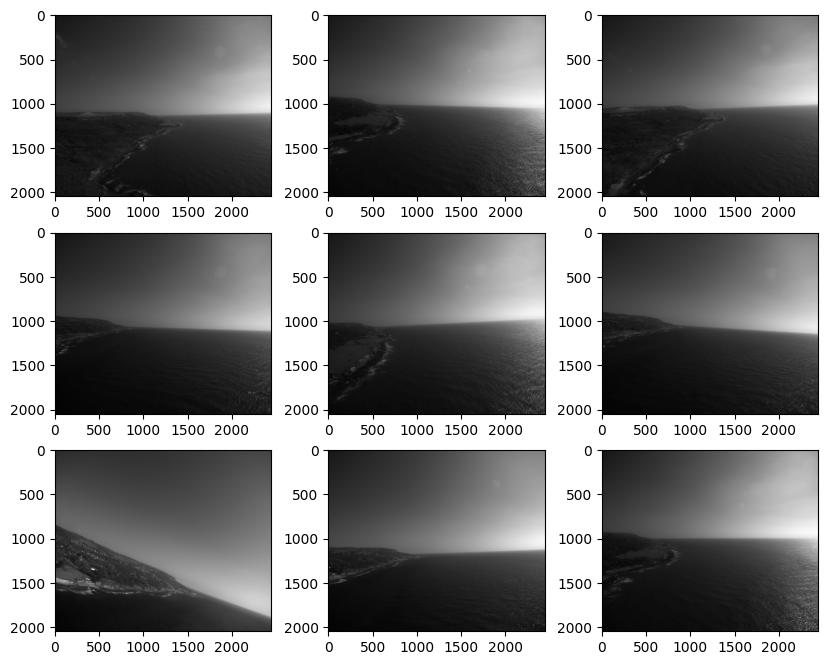

In [7]:
# get the directory of the current script
script_dir = os.getcwd()

# construct relative path to the airborne_images folder
image_folder = os.path.join(script_dir, '..', 'raw_data', 'airborne_images')

# list the images in the folder
image_files = [f for f in os.listdir(image_folder) if f.endswith('.png')]

fig = plt.figure(figsize=(10,8))

for i in range(1, 10):
    img = cv2.imread(os.path.join(image_folder, image_files[i]))
    fig.add_subplot(3, 3, i)
    plt.imshow(img, cmap='gray')

plt.show()

In [8]:
img_test_1 = cv2.imread(os.path.join(image_folder, image_files[0]))

original_height, original_width, _ = img_test_1.shape

print(f"Width: {original_width} pixels, Height: {original_height} pixels")

Width: 2448 pixels, Height: 2048 pixels


# Process data

In [9]:
script_dir = os.getcwd()
dataset_dir = os.path.join(script_dir, '..', 'raw_data', 'airborne_images')
resized_dir = os.path.join(script_dir, '..', 'raw_data', 'airborne_images_resized')

In [ ]:
# # desired shorter side length
# short_side_length = 800

# # create output directory if it doesn't exist
# if not os.path.exists(resized_dir):
#     os.makedirs(resized_dir, exist_ok=True)

# # get list of image files
# flight_images = os.listdir(dataset_dir)
# resized_count = 0

# # resize images
# for image_file in flight_images:
#     if image_file.endswith('.png'):
#         # load image
#         image_path = os.path.join(dataset_dir, image_file)
#         image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

#         if image is None:
#             print(f'Error loading image: {image_file}')
#             continue

#         # get current dimensions
#         h, w = image.shape[:2]

#         # calculate the new size maintaining aspect ratio
#         if w > h:
#             new_w = short_side_length
#             new_h = int((h / w) * short_side_length)
#         else:
#             new_h = short_side_length
#             new_w = int((w / h) * short_side_length)

#         # resize image
#         resized_image = cv2.resize(image, (new_w, new_h), interpolation=cv2.INTER_AREA)

#         # save resized image
#         output_path = os.path.join(resized_dir, image_file)
#         cv2.imwrite(output_path, resized_image)
#         resized_count += 1

# print(f"Resized {resized_count} images and saved to: {resized_dir}")


## Scaling

In [10]:
img_resized_test_1 = cv2.imread(os.path.join(resized_dir, image_files[0]))

resized_height, resized_width, _ = img_resized_test_1.shape

print(f"Resized Width: {resized_width} pixels, Resized Height: {resized_height} pixels")

Resized Width: 800 pixels, Resized Height: 669 pixels


In [11]:
gt_data_resized = gt_data.copy()

In [12]:
gt_data_resized['size_height'] = resized_height
gt_data_resized['size_width'] = resized_width

print(gt_data_resized['size_height'].unique())
print(gt_data_resized['size_width'].unique())

[669]
[800]


In [13]:
# calculate scaling factors
scale_x = resized_width / original_width
scale_y = resized_height / original_height

# resize bounding boxes
def resize_bbox(row):
    if pd.notna(row['gt_left']):
        row['gt_left'] = int(row['gt_left'] * scale_x)
        row['gt_right'] = int(row['gt_right'] * scale_x)
        row['gt_top'] = int(row['gt_top'] * scale_y)
        row['gt_bottom'] = int(row['gt_bottom'] * scale_y)
    return row

# apply the resizing to the bounding boxes
gt_data_resized = gt_data.apply(resize_bbox, axis=1)

## NaN values

In [14]:
# fill nan bounding box values with 0.0
for col in ['gt_left', 'gt_top', 'gt_right', 'gt_bottom']:
    gt_data_resized[col] = gt_data_resized[col].fillna(0.0)
    gt_data_resized[col] = pd.to_numeric(gt_data_resized[col], errors='coerce')

# create the bbox column as a tensor-like list for each row
gt_data_resized['bbox'] = gt_data_resized.apply(
    lambda row: [row['gt_left'], row['gt_top'], row['gt_right'], row['gt_bottom']],
    axis=1
    )


In [15]:
gt_data_resized['is_above_horizon'] = gt_data_resized['is_above_horizon'].fillna(9999)
gt_data_resized['range_distance_m'] = gt_data_resized['range_distance_m'].fillna(-9999)

In [16]:
len(gt_data_resized)

1808316

In [17]:
# list of all possible objects including NaN
objects = [np.nan, 'Airplane3', 'Airplane2', 'Airplane1', 'Helicopter1', 'Bird2',
           'Bird3', 'Airborne2', 'Airborne1', 'Bird1', 'Bird5', 'Airborne3',
           'Bird4', 'Drone1', 'Flock1', 'Helicopter2', 'Helicopter3', 'Flock2',
           'Bird6', 'Bird7', 'Airborne4', 'Airplane4', 'Airborne6', 'Airborne5',
           'Airplane5', 'Bird8', 'Bird9', 'Bird22', 'Bird20', 'Bird21', 'Bird16',
           'Bird15', 'Bird11', 'Bird17', 'Bird18', 'Bird19', 'Bird10', 'Bird12',
           'Bird14', 'Bird13', 'Bird23', 'Airplane6', 'Airborne9', 'Airborne15',
           'Airborne7', 'Airborne8', 'Airborne14', 'Airborne10', 'Airborne11',
           'Airborne12', 'Airborne13', 'Airplane7', 'Airplane10', 'Airplane8',
           'Airplane9', 'Flock3', 'Airborne16', 'Airborne18', 'Airborne17',
           'Airborne19', 'Bird25', 'Bird24']

# step 1: dictionary object names to integer labels
object_to_label = {obj: i for i, obj in enumerate(objects)}

# assign 0 to NaN (no object)
object_to_label[np.nan] = 0

object_to_label

{nan: 0,
 'Airplane3': 1,
 'Airplane2': 2,
 'Airplane1': 3,
 'Helicopter1': 4,
 'Bird2': 5,
 'Bird3': 6,
 'Airborne2': 7,
 'Airborne1': 8,
 'Bird1': 9,
 'Bird5': 10,
 'Airborne3': 11,
 'Bird4': 12,
 'Drone1': 13,
 'Flock1': 14,
 'Helicopter2': 15,
 'Helicopter3': 16,
 'Flock2': 17,
 'Bird6': 18,
 'Bird7': 19,
 'Airborne4': 20,
 'Airplane4': 21,
 'Airborne6': 22,
 'Airborne5': 23,
 'Airplane5': 24,
 'Bird8': 25,
 'Bird9': 26,
 'Bird22': 27,
 'Bird20': 28,
 'Bird21': 29,
 'Bird16': 30,
 'Bird15': 31,
 'Bird11': 32,
 'Bird17': 33,
 'Bird18': 34,
 'Bird19': 35,
 'Bird10': 36,
 'Bird12': 37,
 'Bird14': 38,
 'Bird13': 39,
 'Bird23': 40,
 'Airplane6': 41,
 'Airborne9': 42,
 'Airborne15': 43,
 'Airborne7': 44,
 'Airborne8': 45,
 'Airborne14': 46,
 'Airborne10': 47,
 'Airborne11': 48,
 'Airborne12': 49,
 'Airborne13': 50,
 'Airplane7': 51,
 'Airplane10': 52,
 'Airplane8': 53,
 'Airplane9': 54,
 'Flock3': 55,
 'Airborne16': 56,
 'Airborne18': 57,
 'Airborne17': 58,
 'Airborne19': 59,
 'Bird25': 

In [18]:
# step 2: mapping to df
gt_data_resized['id_object'] = gt_data_resized['id'].map(object_to_label)

In [19]:
len(gt_data_resized)

1808316

In [20]:
gt_data_resized = gt_data_resized.drop(columns=['id', 'gt_left', 'gt_top',
       'gt_right', 'gt_bottom'])

In [21]:
gt_data_resized.info()


<class 'pandas.core.frame.DataFrame'>
Index: 1808316 entries, 0 to 1808315
Data columns (total 10 columns):
 #   Column            Dtype  
---  ------            -----  
 0   time              int64  
 1   flight_id         object 
 2   img_name          object 
 3   frame             int64  
 4   range_distance_m  float64
 5   is_above_horizon  float64
 6   size_width        int64  
 7   size_height       int64  
 8   bbox              object 
 9   id_object         int64  
dtypes: float64(2), int64(5), object(3)
memory usage: 151.8+ MB


In [23]:
gt_data_resized.to_csv(os.path.join(dataset_folder, 'gt_df.csv'))

In [34]:
gt_data_resized['bbox'].iloc[0][0]

0.0

# Select a flight for testing

In [35]:
flight_id = '0001ba865c8e410e88609541b8f55ffc'
gt_df = gt_data_resized[gt_data_resized['flight_id'] == flight_id]

In [36]:
gt_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1199 entries, 684441 to 685639
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   time              1199 non-null   int64  
 1   flight_id         1199 non-null   object 
 2   img_name          1199 non-null   object 
 3   frame             1199 non-null   int64  
 4   range_distance_m  1199 non-null   float64
 5   is_above_horizon  1199 non-null   float64
 6   size_width        1199 non-null   int64  
 7   size_height       1199 non-null   int64  
 8   bbox              1199 non-null   object 
 9   id_object         1199 non-null   int64  
dtypes: float64(2), int64(5), object(3)
memory usage: 103.0+ KB


In [37]:
gt_df['bbox'].iloc[0][0]

475.0

In [38]:
import ast

# Saving the DataFrame to CSV
gt_df.to_csv(os.path.join(dataset_folder, 'gt_df.csv'), index=False)

# Loading the DataFrame back and converting bbox from string to list
gt_df = pd.read_csv(os.path.join(dataset_folder, 'gt_df.csv'))

# Convert bbox column back to lists
gt_df['bbox'] = gt_df['bbox'].apply(ast.literal_eval)

In [39]:
gt_df['bbox'].iloc[0][0]

475.0

# Split data

In [40]:
train_val, test = train_test_split(gt_df, test_size=0.2, random_state=42)
train, val = train_test_split(train_val, test_size=0.2, random_state=42)

print(f"Train size: {len(train)}")
print(f"Validation size: {len(val)}")
print(f"Test size: {len(test)}")

Train size: 767
Validation size: 192
Test size: 240


In [41]:
train['bbox'].iloc[0][0]

468.0

# Create data object

In [42]:
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torchvision.transforms as transforms

class AirborneObjectDataset(Dataset):
    def __init__(self, data, img_dir, transform=None):
        self.data = data
        self.img_dir = img_dir
        self.transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Lambda(lambda x: x.repeat(3, 1, 1))
        ])

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        img_name = row['img_name']
        img_path = os.path.join(self.img_dir, img_name)

        image = Image.open(img_path).convert('L')
        if self.transform:
            image = self.transform(image)

        bbox = torch.tensor(row['bbox'], dtype=torch.float32)
        label = torch.tensor([row['id_object']], dtype=torch.int64)

        # check if the box is valid (non-zero area)
        if bbox[2] > bbox[0] and bbox[3] > bbox[1]:
            target = {
                'boxes': bbox.unsqueeze(0),
                'labels': label
            }
        else:
            # if bbox is invalid zero, replace with empty tensor
            target = {
                'boxes': torch.zeros((0, 4), dtype=torch.float32),
                'labels': torch.zeros(0, dtype=torch.int64)
            }

        return image, target


In [43]:
# create the dataset
def collate_fn(batch):
    images = []
    targets = []
    for img, target in batch:
        images.append(img)
        targets.append(target)
    return images, targets

train_dataset = AirborneObjectDataset(train, img_dir=resized_dir)
val_dataset = AirborneObjectDataset(val, img_dir=resized_dir)
test_dataset = AirborneObjectDataset(test, img_dir=resized_dir)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn)

# Create model

In [44]:
import torch
import torchvision
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator
from torchvision.transforms import functional as F
from torchvision.models.detection.backbone_utils import resnet_fpn_backbone
from torchvision.models import ResNet50_Weights
from torch.optim.lr_scheduler import StepLR


The `create_model` function does not take into account all the features of the dataset.

In [45]:
def create_model(num_classes):
    # use pre-trained resnet fpn backbone
    backbone = resnet_fpn_backbone(
        backbone_name='resnet50',
        weights=ResNet50_Weights.IMAGENET1K_V1,
        trainable_layers=5
    )

    # define anchor sizes and aspect ratios suited for airborne objects
    anchor_generator = AnchorGenerator(
        sizes=((32,), (64,), (128,), (256,), (512,)),
        aspect_ratios=((0.5, 1.0, 2.0),) * 5
    )

    # define model
    model = FasterRCNN(
        backbone=backbone,
        num_classes=num_classes,
        rpn_anchor_generator=anchor_generator,
        box_detections_per_img=10,
        box_nms_thresh=0.5,
        box_score_thresh=0.05
    )

    return model


num_classes = 2  # 1 for helicopter, 1 for background
model = create_model(num_classes)


In [46]:
# move model to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

model = model.to(device)

Using device: cpu


In [47]:
# define optimizer
optimizer = torch.optim.SGD(
    model.parameters(),
    lr=0.005,
)
# define learning rate scheduler
scheduler = StepLR(optimizer, step_size=3, gamma=0.1)


# Train model

In [48]:
def train_one_epoch(model, optimizer, data_loader, device):
    model.train()
    total_loss = 0
    num_batches = 0

    for batch_idx, (images, targets) in enumerate(data_loader):
        try:
            images = list(image.to(device) for image in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            loss_dict = model(images, targets)
            losses = sum(loss for loss in loss_dict.values())

            optimizer.zero_grad()
            losses.backward()
            optimizer.step()

            total_loss += losses.item()
            num_batches += 1

            if batch_idx % 10 == 0:  # Print every 10 batches
                print(f"Batch {batch_idx}, Loss: {losses.item():.4f}")
        except Exception as e:
            print(f"Error in batch {batch_idx}: {str(e)}")
            print(f"Images shape: {[img.shape for img in images]}")
            print(f"Targets: {targets}")
            continue

    return total_loss / num_batches if num_batches > 0 else 0


In [49]:
# training loop
num_epochs = 1
for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")
    train_loss = train_one_epoch(model, optimizer, train_loader, device)
    print(f"Epoch {epoch+1}, Training Loss: {train_loss:.4f}")

    val_loss = validate(model, val_loader, device)
    print(f"Epoch {epoch+1}, Validation Loss: {val_loss:.4f}")

    scheduler.step()

print("Training complete!")

Epoch 1/1


# Validate model

In [ ]:
def validate(model, data_loader, device):
    model.eval()
    total_loss = 0

    with torch.no_grad():
        for images, targets in data_loader:
            images = list(image.to(device) for image in images)
            targets = [{k: v.to(device) for k, v in t.items() if k in ['boxes', 'labels']} for t in targets]

            loss_dict = model(images, targets)
            losses = sum(loss for loss in loss_dict.values())
            total_loss += losses.item()

    avg_loss = total_loss / len(data_loader)
    print(f"Validation Loss: {avg_loss:.4f}")
    return avg_loss

# define number of epochs
num_epochs = 1

In [ ]:
type(df_testing['bbox'].iloc[0][0])
